# fieldgen and siggen

<b>fieldgen and siggen are used together to produce simulated signals.</b>

They use a common config file to define the detector geometry, impurity profile, file names, etc. Those config files will let you describe an ICPC detector, a PPC detector, a BEGe, or even a coaxial detector.

fieldgen is a stand-alone program used to calculate the electric and weighting potentials inside a detector.

siggen is a library of functions to use those potentials, together with charge mobilities and Remo's theorem, to calculate signals.
stester (signal_tester.c) is an example code using the siggen library. It can be used to produce signals from any valid location inside the detector. Or you can use it as a template to build your own special-purpose code.

You can get the codes from github:

git clone https://github.com/radforddc/icpc_siggen.git

cd icpc_siggen; make

<b>To run this notebook, first move it into the icpc_siggen directory.</b>


### Config file example: Mirion crystal number 50372

Here is an example of a config file for a very recent crystal blank from Mirion. It specifies the geometry for a 4-kg ICPC detector.

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
import shutil
import struct
import pickle
from collections import Counter
from tqdm import tqdm
from sklearn.cluster import DBSCAN
import glob  # import the glob module to find all the files matching a pattern

In [2]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import os
import time
import random
import torch
import pickle
import torch.nn as nn
import torch.optim as optim
from torch.nn.parameter import Parameter
from torch.nn import init
import torch.nn.functional as F
import torch.utils.data as data_utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import numpy as np
from torch.autograd import Variable
from scipy import sparse
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# import torchsnooper
from scipy import signal
from torch import nn, einsum
import matplotlib.gridspec as gridspec
import itertools
from scipy.stats import norm
from scipy.optimize import curve_fit


# Activate your environment:
# If your environment is not already active, you can activate it using the following command:
# source /nas/longleaf/home/kbhimani/cpu_net_env/bin/activate

In [3]:
siggen_dir='/nas/longleaf/home/kbhimani/cpu_net_sims/WFSimulation/icpc_siggen/'
clust_dir= "/nas/longleaf/home/kbhimani/cpu_net_sims/clust_data/"
waveform_dir="/work/users/k/b/kbhimani/cpu_net_siggen_sims/waveforms/"
save_dir="/nas/longleaf/home/kbhimani/cpu_net_sims/waveforms/"

# siggen_dir='/Users/kevinhbhimani/Desktop/cpu_net_sims/WFSimulation/icpc_siggen/'
# clust_dir= "/Users/kevinhbhimani/Desktop/cpu_net_sims/clust_data/"
# waveform_dir="/Users/kevinhbhimani/Desktop/waveforms/"
# save_dir="/Users/kevinhbhimani/Desktop/cpu_net_sims/waveforms/"


os.chdir(siggen_dir)
z_cut = 152.9-30/2

In [4]:
import pickle
import os

def combine_pickle_files(sim1, sim2, output_file_path):
    # Open the output file
    with open(output_file_path, 'wb') as output_file:
        # Process each input file
        for sim_file in [sim1, sim2]:
            with open(sim_file, 'rb') as file:
                while True:
                    try:
                        # Load each pickled object and save it to the output file
                        data = pickle.load(file)
                        pickle.dump(data, output_file, protocol=pickle.HIGHEST_PROTOCOL)
                    except EOFError:
                        break  # End of file reached, move to the next file

    print(f"Combined data saved in: {output_file_path}")

# Paths to your input files and the output file
sim1 = save_dir + "sep_sim.pickle"
sim2 = save_dir + "SimulatedPulses.pickle"
output_file_path = save_dir + 'combined_sep_sim.pickle'

# Combine the files
combine_pickle_files(sim1, sim2, output_file_path)

FileNotFoundError: [Errno 2] No such file or directory: '/nas/longleaf/home/kbhimani/cpu_net_sims/waveforms/combined_sep_sim.pickle'

## Running mjd_fieldgen

To see command format and options, run the code with no command line parameters.

You normally run mjd_fieldgen with the config file name as the first parameter, followed by any other desired options.

Here I am running it with the config file given above:

In [4]:
import subprocess
subprocess.run("./mjd_fieldgen config_files/bege_Sp.config",
                check=True, shell=True).stdout
#subprocess.run("./mjd_fieldgen config_files/50372.config -b 4650", check=False, shell=True).stdout
#subprocess.run("./mjd_fieldgen config_files/coax_50372.config -b 6000", check=False, shell=True).stdout


Reading values from config file config_files/bege_Sp.config
verbosity_level: 2
Line: xtal_length         30   # z length
xtal_length: 30.000000
Line: xtal_radius         35   # radius
xtal_radius: 35.000000
Line: pc_length            0   # point contact length
pc_length: 0.000000
Line: pc_radius            4   # point contact radius
pc_radius: 4.000000
Line: wrap_around_radius  12   # wrap-around radius
wrap_around_radius: 12.000000
Line: ditch_depth          2   # depth of ditch next to wrap-around
ditch_depth: 2.000000
Line: ditch_thickness      4   # width of ditch next to wrap-around
ditch_thickness: 4.000000
Line: Li_thickness       1.0   # depth of full-charge-collection boundary for Li contact
Li_thickness: 1.000000
Line: xtal_grid          0.1   # grid size in mm for field files (usually 0.5 or 0.1 mm)
xtal_grid: 0.100000
Line: impurity_z0       -1.1   # net impurity concentration at Z=0, in 1e10 e/cm3
impurity_z0: -1.100000
Line: impurity_gradient  0.16   # net impurity gardi

### What is that "-r config_files/mirion_enr/50372.spe -z 10"? Is it needed?

<b>For simple detectors, and ones with a nice linear impurity profile, these options are not needed.</b> The impurity profile can simply be parameterized and put into the config file.

However, when optimizing the use of large enriched crystals like this one for making LEGEND detectors, we want to be as accurate as possible in our simulations. For this very large detector, these options allow me to use the 50372.spe file as the profile of the net impurity along the z-axis of the detector, and give the most accurate information that I have to the fieldgen calculation. 

50372.spe is a fit to the impurity profile provided by the manufacturer (Mirion). Each bin corresponds to 1 mm, and the impurity units are (1e10 / cm3).

The input impurity profile is plotted in the next cell below.

The "-z 10" option tells the code that the detector is not using the first 10 mm of the crystal; that material has too high an impurity value.

To see the effect of using a detailed impurity like this, try re-running fieldgen without those options: "./mjd_fieldgen config_files/mirion_enr/50372.config". You will see that the depletion voltage changes.

In [1]:
import sys
import numpy as np
import struct
import matplotlib.pyplot as plt
# plot the fitted impurity profile
f = open("config_files/50372.spe", 'rb')
head = f.read(36)
yraw = f.read(130*4)
y = np.array(struct.unpack('f'*130, yraw))
plt.rcParams["figure.figsize"] = 12, 6
plt.plot(y)
# plot it with the10-mm offset
plt.plot(y[10:])
# plot the data points provided by Mirion
x = [0,    21,   71,   121]
y = [-2.3, -1.4, -0.9, -0.8]
plt.plot(x, y, "bo")
plt.xlabel("z [mm]", size=13)
plt.ylabel("net impurity [1e10/cm3]", labelpad=8,  size=13)
plt.title("input impurity profile\n", fontsize=16, linespacing=0.4)
plt.grid(True)
plt.show()
f.close()

FileNotFoundError: [Errno 2] No such file or directory: 'config_files/50372.spe'

## Plotting the electric field or weighting potential

You can use fields/plot_log.py from the terminal to make plots like this from the shell. Here I have excerpted parts of that code to plot the field calculated above.

(105651, 3)
(-35.0, 35.0, 0.0, 30.0)


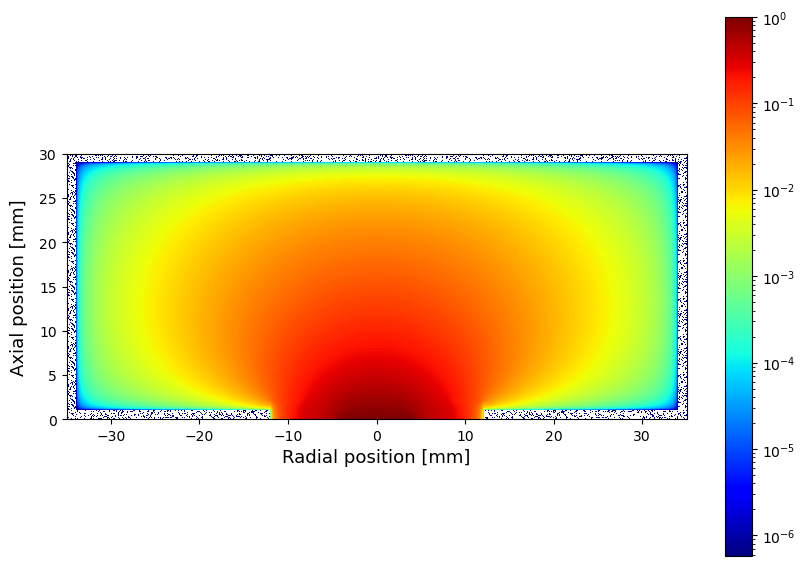

In [7]:
import matplotlib.colors as colors

data = np.loadtxt("fields/wp_bg.dat")
#data = np.loadtxt("fields/ev_c50372.dat")
# figure out the size of grid the X-Y points
x = set(data[:,0])  # sets only have one copy of anything, so if there are repeats, they are removed
y = set(data[:,1])
print(data.shape)
z = data[:,2]       # column 3 = field, 2 = potential
# reshape the zvals array into the appropriate shape, and find the boundaries
zvals = z.reshape(len(x), len(y))
zvals[zvals<0] = 0
# imshow plots columns and rows opposite to how you'd expect; so transpose them
zvals = zvals.T
# stack so we can plot the data from one half of the detector (positive r-values only)
zvals_neg = np.fliplr(zvals)
zvals_full = np.hstack((zvals_neg,zvals))
bounds = (-1*max(x), max(x), min(y), max(y))
print(bounds)

fig = plt.figure(figsize=(10,7))
ip = plt.imshow(zvals_full, norm=colors.LogNorm(),
                extent=bounds,   # set the boundaries of the edges of the 'image' data
                origin="lower",  # tell matplotlib where [0,0] is in the bottom
                cmap='jet')      # use the 'jet color map scheme
plt.xlabel("Radial position [mm]", size=13)
plt.ylabel("Axial position [mm]", labelpad=8,  size=13)
plt.colorbar()
plt.show()

### How big is that detector?

Use the "mass" program to calculate the detector mass, for either natural or enriched material.

In [8]:
subprocess.run("./mass config_files/bege_Sp.config", check=False, shell=True).stdout


Reading values from config file config_files/bege_Sp.config
verbosity_level: 2
Line: xtal_length         30   # z length
xtal_length: 30.000000
Line: xtal_radius         35   # radius
xtal_radius: 35.000000
Line: pc_length            0   # point contact length
pc_length: 0.000000
Line: pc_radius            4   # point contact radius
pc_radius: 4.000000
Line: wrap_around_radius  12   # wrap-around radius
wrap_around_radius: 12.000000
Line: ditch_depth          2   # depth of ditch next to wrap-around
ditch_depth: 2.000000
Line: ditch_thickness      4   # width of ditch next to wrap-around
ditch_thickness: 4.000000
Line: Li_thickness       1.0   # depth of full-charge-collection boundary for Li contact
Li_thickness: 1.000000
Line: xtal_grid          0.1   # grid size in mm for field files (usually 0.5 or 0.1 mm)
xtal_grid: 0.100000
Line: impurity_z0       -1.1   # net impurity concentration at Z=0, in 1e10 e/cm3
impurity_z0: -1.100000
Line: impurity_gradient  0.16   # net impurity gardi

## Running siggen (stester)

The siggen functiona can be compiled with your own glue code to do whatever tailored task you need.
But if you just want to generate some signals then you'll probably find that the example code stester will do what you want.

stester is an interactive command-driven program. You could easily run it inside a terminal, for example with the command: 

./stester config_files/mirion_enr/50372.config

To get a list of the stester commands, type the command "help".
To exit the program, type the command "quit".

To show examples in this Jupyter Notebook, I'm using a work-around to pre-write my commands to stester into a file, and then redirecting the stester input from that file.


In [3]:
# To get a list of the stester commands, type "help"
f = open("my_stester_commands.txt", "w")
f.write("help\n")
f.write("quit\n")
f.close()
subprocess.run("./stester config_files/bege_Sp.config < my_stester_commands.txt", 
               check=False, shell=True).stdout


Reading values from config file config_files/bege_Sp.config
verbosity_level: 2
Line: xtal_length         30   # z length
xtal_length: 30.000000
Line: xtal_radius         35   # radius
xtal_radius: 35.000000
Line: pc_length            0   # point contact length
pc_length: 0.000000
Line: pc_radius            4   # point contact radius
pc_radius: 4.000000
Line: wrap_around_radius  12   # wrap-around radius
wrap_around_radius: 12.000000
Line: ditch_depth          2   # depth of ditch next to wrap-around
ditch_depth: 2.000000
Line: ditch_thickness      4   # width of ditch next to wrap-around
ditch_thickness: 4.000000
Line: Li_thickness       1.0   # depth of full-charge-collection boundary for Li contact
Li_thickness: 1.000000
Line: xtal_grid          0.1   # grid size in mm for field files (usually 0.5 or 0.1 mm)
xtal_grid: 0.100000
Line: impurity_z0       -1.1   # net impurity concentration at Z=0, in 1e10 e/cm3
impurity_z0: -1.100000
Line: impurity_gradient  0.16   # net impurity gardi

### Here is an example of using stester to produce a couple of signals from different locations in the detector.

To generate a signal as a radware .spe file. use the "sig" command:

sig x y z output_file.spe or sig r phi z output_file.spe ; coordinates are in mm or radians

In [4]:
import os
os.remove("my_stester_commands.txt")
f = open("my_stester_commands.txt", "w")
f.write("tau 6.8\n")
f.write("ccs 4.8\n")
# f.write("sig 4.3 24.4 22.5 /global/cfs/projectdirs/legend/users/liaobo77/WFSimulation/icpc_siggen/test1.spe\n")
f.write("sig 4.3 24.4 22.5 " + siggen_dir + "test1.spe\n")

f.write("tau 6.8\n")
f.write("ccs 4.8\n")
f.write("sig 4.3 24.4 20 " + siggen_dir + "test2.spe\n")
f.write("quit\n")
f.close()
subprocess.run("./stester config_files/50372.config < my_stester_commands.txt", check=False, shell=True).stdout
#subprocess.run("./stester config_files/coax_50372.config < my_stester_commands.txt", check=False, shell=True).stdout


Reading values from config file config_files/50372.config
Will use 8000 time steps in calculations, each 1.00 ns long;
the output signals will have 800 time steps, each 10.00 ns long
Reading field data...
rmin: 0.00 rmax: 46.00, rstep: 0.20
zmin: 0.00 zmax: 111.00, zstep: 0.20
Detector temperature is set to 90.0 K
Drift velocity table has 20 rows of data
Adjusting mobilities for temperature, from 77.0 to 90.0
Reading electric field data from file: fields/ev_50372.dat
Done reading 128710 lines of electric field data
Reading weighting potential from file: fields/wp_50372.dat
Done reading 128710 lines of WP data
Setup of signal calculation done
>> tau 6.8
Signals will be integrated with tau = 6.800000 ns
>> ccs 4.8
Charge cloud size set to 4.800000 mm
siggen/test1.spe22.5 /nas/longleaf/home/kbhimani/cpu_net_sims/WFSimulation/icpc_s
t_90, t_10-90, A/E =  350  297 0.050059
800 channels of data saved in spectrum /nas/longleaf/home/kbhimani/cpu_net_sims/WFSimulation/icpc_siggen/test1.spe
>> 

### Here are those two output signals

Blue:   test1.spe ;  (x, y, z)= (30, 0, 95) mm

Orange: test2.spe ;  (x, y, z)= (20, 0, 5) mm

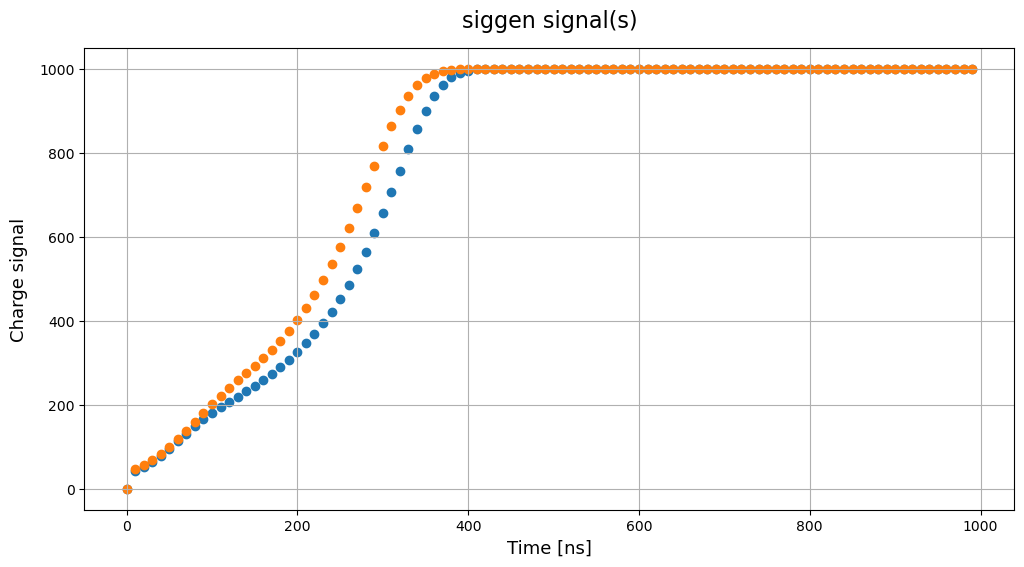

In [11]:
import sys
import numpy as np
import struct
import matplotlib.pyplot as plt
x = np.arange(0, 1000, 10)
f = open("test1.spe", 'rb')
nwfs = 100
head = f.read(36)
yraw = f.read(100*4)
y = np.array(struct.unpack('f'*100, yraw))
ysave = y
plt.scatter(x,y)
f.close()
f = open("test2.spe", 'rb')
head = f.read(36)
yraw = f.read(100*4)
y = np.array(struct.unpack('f'*100, yraw))
plt.scatter(x,y)
plt.xlabel("Time [ns]", size=13)
plt.ylabel("Charge signal", labelpad=8,  size=13)
plt.title("siggen signal(s)\n", fontsize=16, linespacing=0.4)
plt.grid(True)
plt.rcParams["figure.figsize"] = 12, 6
plt.show()
f.close()

Now you could try changing the coordinates in the stester "sig" commands above (In [8]), and see how the signals change.

Try changing the config file in the call to fieldgen (In [3]) from 50372.config to coax_50372.config. That will produce a different field file (ev_c50372.dat instead of ev_50372.dat). In order to see it you will need to change the filename in In [5] from ev_50372.dat to ev_c50372.dat.

Then you can rerun stester (In [8]) also with that coax_50372.config file. The signals will look very different for this coaxial detector!

Compare 50372.config and coax_50372.config to see how they differ for the two geometries.


In [17]:
def count_frequencies(his_point):
    """
    Function to count the frequencies of unique elements in a list.
    
    Parameters:
    his_point (list or np.array): Input list or numpy array of elements.
    
    Returns:
    np.array: A numpy array containing the frequencies of each unique element.
    """
    n = len(his_point)
    arr = his_point
    visited = [False for i in range(n)]
    counts = []  # Using a list for collecting counts
    
    # Traverse through array elements and count frequencies
    for i in range(n):
        # Skip this element if already processed
        if visited[i] == True:
            continue
        
        # Count frequency
        count = 1
        for j in range(i + 1, n):
            if arr[i] == arr[j]:
                visited[j] = True
                count += 1
        # if count>5:
        #     print(n)
        counts.append(count)  # Append to the list
    
    return np.array(counts)  # Convert to numpy array at the end

In [19]:
%%time
#change file save and energy_cut
import pandas as pd
import h5py
import numpy as np
from tqdm import tqdm
from sklearn.cluster import DBSCAN
def clust_center(x_val, e_vals):
    return np.sum(x_val * e_vals) / np.sum(e_vals)
for run_num in tqdm(range(0,1)):
    g4sfile_name = "/work/users/k/b/kbhimani/cpu_net_g4sims/data/data_run_" + str(run_num) + ".hdf5"
    # print("procession file:", g4sfile_name)
    g4sfile = h5py.File(g4sfile_name, 'r')
    g4sntuple = g4sfile['default_ntuples']['g4sntuple']
    # print("Importing data")
    # # # SEP CUTs 2.1035
    energy_cut_l= 2.101
    energy_cut_h= 2.106
    
    # # SEP BACK CUTs 2.1035
    # energy_cut_l= 2.094
    # energy_cut_h= 2.099
    
    
    # #FEP CUTs 2.6145
    # energy_cut_l= 2.613
    # energy_cut_h= 2.616
    
    # #DEP Cuts 1.5925
    # energy_cut_l= 1.5915
    # energy_cut_h= 1.5945
    
    #DEP Back ground Cuts 1.5925
    # energy_cut_l= 1.588
    # energy_cut_h= 1.591   

    # Creating a DataFrame
    g4sdf = pd.DataFrame({
        'x_hit': np.array(g4sntuple['x']['pages']),
        'y_hit': np.array(g4sntuple['y']['pages']),
        'z_hit': np.array(g4sntuple['z']['pages']),
        'event': np.array(g4sntuple['event']['pages']),
        'Edep': np.array(g4sntuple['Edep']['pages']),
        'volID': np.array(g4sntuple['volID']['pages']),
        'iRep': np.array(g4sntuple['iRep']['pages'])
    })

    # print("Processing data")
    # Filtering and grouping operations
    detector_hits = g4sdf[(g4sdf.Edep > 0) & (g4sdf.volID == 1)]

    # Group by 'event' and sum the 'Edep' values, and rename the column to 'total_energy'
    grouped_hits = detector_hits.groupby('event', as_index=False).agg({'Edep': 'sum'}).rename(columns={'Edep': 'total_energy'})

    # Filter to include only rows where the total 'total_energy' is between 2.1 and 2.105
    selected_events = grouped_hits[(grouped_hits['total_energy'] > energy_cut_l) & (grouped_hits['total_energy'] < energy_cut_h)]

    # Merge the total energy information back to the original DataFrame based on the 'event'
    selected_events_detailed = detector_hits.merge(selected_events, on='event', how='right')

    # Now, the 'selected_events_detailed' DataFrame should have all the original columns plus the 'total_energy' column.
    # print("Unique events in the run", len(np.unique(selected_events_detailed["event"])))

    clust_eps = 0.5 # distance for which two points are considered neighbors in DBSCAN
    event_list = np.unique(selected_events_detailed["event"])
    g4sfile.close()

    # print("Running clustering")
    model = DBSCAN(eps=clust_eps)

    all_dfs = []  # A list to hold individual DataFrames
    for i in event_list:

        data_load = selected_events_detailed[selected_events_detailed["event"] == i]
        e_event = data_load["Edep"].sum()  # Total energy for the event
        data = data_load[['x_hit', 'y_hit', 'z_hit']]
        if i==634:
            plt.plot(data["x_hit"],data["y_hit"])
        pred = model.fit_predict(data)
        for lab in set(model.labels_):
            mask = model.labels_ == lab
            filtered_data = data_load[mask]

            x_clust_temp = clust_center(filtered_data["x_hit"], filtered_data["Edep"])
            y_clust_temp = clust_center(filtered_data["y_hit"], filtered_data["Edep"])
            z_clust_temp = clust_center(filtered_data["z_hit"], filtered_data["Edep"])
            e_clust_temp = filtered_data["Edep"].sum()  # Using the mask for consistency

            num_points = len(filtered_data)  # Directly use the length of filtered_data

            df2 = pd.DataFrame([[x_clust_temp, y_clust_temp, z_clust_temp, e_clust_temp, e_event, int(i), num_points]],
                               columns=['x_hit', 'y_hit', 'z_hit', 'e_hit', 'e_event', 'event', 'num_points'])
            all_dfs.append(df2)  # Append DataFrame to the list

    # Concatenate all DataFrames at once
    sim_df = pd.concat(all_dfs, ignore_index=True)

    file_save = '/nas/longleaf/home/kbhimani/cpu_net_sims/clust_data/sep/cpu_net_data_clust_' + str(run_num) + '.h5'
    # print(f"Saving output to file {file_save}")
    sim_df.to_hdf(file_save, key='sim_df', mode='w')  # Simplified saving to HDF5

100%|██████████| 1/1 [00:09<00:00,  9.62s/it]

CPU times: user 1.51 s, sys: 723 ms, total: 2.24 s
Wall time: 9.62 s


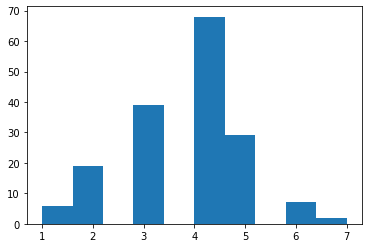

In [21]:
clust_dir = "/nas/longleaf/home/kbhimani/cpu_net_sims/clust_data/sep/"
run_dir= clust_dir+"cpu_net_data_clust_"+str(0)+'.h5'
# print("procession file:", run_dir)
df = pd.read_hdf(run_dir)
edep = df["e_hit"].to_numpy()
e_total = df["e_event"].to_numpy()
x = df["x_hit"].to_numpy()
y = df["y_hit"].to_numpy()
z = df["z_hit"].to_numpy()
event = df["event"].to_numpy()
x=plt.hist(count_frequencies(event))

In [20]:
g4sfile_name = "/work/users/k/b/kbhimani/cpu_net_g4sims/data/data_run_" + str(0) + ".hdf5"
# print("procession file:", g4sfile_name)
g4sfile = h5py.File(g4sfile_name, 'r')
g4sntuple = g4sfile['default_ntuples']['g4sntuple']
# print("Importing data")
# # # SEP CUTs 2.1035
energy_cut_l= 2.101
energy_cut_h= 2.106

# # SEP BACK CUTs 2.1035
# energy_cut_l= 2.094
# energy_cut_h= 2.099


# #FEP CUTs 2.6145
# energy_cut_l= 2.613
# energy_cut_h= 2.616

# #DEP Cuts 1.5925
# energy_cut_l= 1.5915
# energy_cut_h= 1.5945

#DEP Back ground Cuts 1.5925
# energy_cut_l= 1.588
# energy_cut_h= 1.591   

# Creating a DataFrame
g4sdf = pd.DataFrame({
    'x_hit': np.array(g4sntuple['x']['pages']),
    'y_hit': np.array(g4sntuple['y']['pages']),
    'z_hit': np.array(g4sntuple['z']['pages']),
    'event': np.array(g4sntuple['event']['pages']),
    'Edep': np.array(g4sntuple['Edep']['pages']),
    'volID': np.array(g4sntuple['volID']['pages']),
    'iRep': np.array(g4sntuple['iRep']['pages'])
})

# print("Processing data")
# Filtering and grouping operations
detector_hits = g4sdf[(g4sdf.Edep > 0) & (g4sdf.volID == 1)]

# Group by 'event' and sum the 'Edep' values, and rename the column to 'total_energy'
grouped_hits = detector_hits.groupby('event', as_index=False).agg({'Edep': 'sum'}).rename(columns={'Edep': 'total_energy'})

# Filter to include only rows where the total 'total_energy' is between 2.1 and 2.105
selected_events = grouped_hits[(grouped_hits['total_energy'] > energy_cut_l) & (grouped_hits['total_energy'] < energy_cut_h)]

# Merge the total energy information back to the original DataFrame based on the 'event'
selected_events_detailed = detector_hits.merge(selected_events, on='event', how='right')

# Now, the 'selected_events_detailed' DataFrame should have all the original columns plus the 'total_energy' column.
# print("Unique events in the run", len(np.unique(selected_events_detailed["event"])))

clust_eps = 0.5 # distance for which two points are considered neighbors in DBSCAN
event_list = np.unique(selected_events_detailed["event"])
print(event_list)

[  47792  204367  347853  372130  372201  384718  408616  446014  496426
  514728  738841  745037  815206  835756  855737  962912  985900 1360902
 1365702 1419366 1527877 1577104 1608765 1689464 1691215 1702509 1703826
 1714732 1728708 1759334 1790514 1888320 1890152 1997879 2022135 2058422
 2124420 2365229 2416328 2423444 2424345 2430579 2464171 2658411 2709943
 2742366 2830829 2877583 2912339 2933777 3053129 3159519 3187091 3199476
 3276717 3303943 3372857 3383101 3439611 3491117 3572048 3641926 3886006
 3977724 4006045 4031446 4164190 4284304 4286332 4405552 4408924 4681049
 4706854 4799177 4851148 4921549 5020115 5192332 5221878 5222648 5266453
 5360632 5486518 5500717 5534995 5546742 5584467 5604734 5671645 5685210
 5763935 5996315 6060369 6069230 6104688 6105742 6119750 6192110 6201693
 6220164 6294723 6325576 6510078 6515058 6667698 6673350 6683822 6740429
 6933294 6971388 7014897 7035657 7093009 7100548 7101791 7117308 7307221
 7335277 7420656 7425341 7442632 7523223 7630826 77

In [ ]:
g4sfile.close()

# print("Running clustering")
model = DBSCAN(eps=clust_eps)

all_dfs = []  # A list to hold individual DataFrames
for i in event_list:

    data_load = selected_events_detailed[selected_events_detailed["event"] == i]
    e_event = data_load["Edep"].sum()  # Total energy for the event
    data = data_load[['x_hit', 'y_hit', 'z_hit']]
    if i==634:
        plt.plot(data["x_hit"],data["y_hit"])
    pred = model.fit_predict(data)
    for lab in set(model.labels_):
        mask = model.labels_ == lab
        filtered_data = data_load[mask]

        x_clust_temp = clust_center(filtered_data["x_hit"], filtered_data["Edep"])
        y_clust_temp = clust_center(filtered_data["y_hit"], filtered_data["Edep"])
        z_clust_temp = clust_center(filtered_data["z_hit"], filtered_data["Edep"])
        e_clust_temp = filtered_data["Edep"].sum()  # Using the mask for consistency

        num_points = len(filtered_data)  # Directly use the length of filtered_data

        df2 = pd.DataFrame([[x_clust_temp, y_clust_temp, z_clust_temp, e_clust_temp, e_event, int(i), num_points]],
                           columns=['x_hit', 'y_hit', 'z_hit', 'e_hit', 'e_event', 'event', 'num_points'])
        all_dfs.append(df2)  # Append DataFrame to the list

# Concatenate all DataFrames at once
sim_df = pd.concat(all_dfs, ignore_index=True)

file_save = '/nas/longleaf/home/kbhimani/cpu_net_sims/clust_data/sep/cpu_net_data_clust_' + str(run_num) + '.h5'
# print(f"Saving output to file {file_save}")
sim_df.to_hdf(file_save, key='sim_df', mode='w')  # Simplified saving to HDF5

In [ ]:
#change save_dir, clust_dir and this line: save_file=save_dir+ "fep_sim"+str(run_num)+".pickle"
import pandas as pd
import numpy as np
import glob  # import the glob module to find all the files matching a pattern
import subprocess
import os
import struct
import pickle
from tqdm import tqdm
siggen_dir='/nas/longleaf/home/kbhimani/cpu_net_sims/WFSimulation/icpc_siggen/'
clust_dir= "/nas/longleaf/home/kbhimani/cpu_net_sims/clust_data/sep/"
waveform_dir="/work/users/k/b/kbhimani/cpu_net_siggen_sims/waveforms/"
save_dir="/nas/longleaf/home/kbhimani/cpu_net_sims/waveforms/run_wfs/sep/"
z_cut = 152.9-30/2
def delete_files_in_directory(directory_path):
    # Get a list of all files in the directory
    files = glob.glob(directory_path + '*')
    for file in files:
        try:
            os.remove(file)  # Try to delete each file
            # print(f"File {file} deleted successfully")
        except Exception as e:
            print(f"An error occurred while deleting the file {file}: {e}")
for run_num in tqdm(range(0,100)):            
    run_dir= clust_dir+"cpu_net_data_clust_"+str(run_num)+'.h5'
    
    # print("procession file:", run_dir)
    df = pd.read_hdf(run_dir)
    edep = df["e_hit"].to_numpy()
    e_total = df["e_event"].to_numpy()
    x = df["x_hit"].to_numpy()
    y = df["y_hit"].to_numpy()
    z = df["z_hit"].to_numpy()
    event = df["event"].to_numpy()
    df.loc[df['z_hit'] > (z_cut), 'z_hit'] -= z_cut
    # print(f"Attempting to write to: {waveform_dir}my_stester_commands.txt")
    f = open(waveform_dir+"my_stester_commands.txt", "w")
    for i in range(0,len(x)):
        f.write("cart \n")
        f.write("tau 0\n")
        f.write("dif 1\n")
        f.write("ccs 0.1\n")
        str1 = "sig %f %f %f "%(x[i],y[i],z[i])
        str2 = waveform_dir+"unstacked_wf/sig_event%d_x_%.4fy_%.4fz_%.4f.spe\n"%(event[i],np.round(x[i],4),np.round(y[i],4),np.round(z[i],4))
        f.write(str1+str2)
    f.write("quit\n")
    f.close()
    # print("Running Siggen to generate waveforms")
    os.chdir(siggen_dir)
    sterster_comand = siggen_dir + "stester " + siggen_dir+ "config_files/bege_Sp.config < " + waveform_dir + "my_stester_commands.txt"
    # print(sterster_comand)
    subprocess.run(sterster_comand, stdout=subprocess.DEVNULL, check=False, shell=True) #, stdout=subprocess.DEVNULL
    wfs=[]
    events_array=[]
    energy_dep=[]
    for j in range(0,len(x)):
        unstack_wf_dir = waveform_dir+"/unstacked_wf/sig_event%d_x_%.4fy_%.4fz_%.4f.spe"%(event[j],np.round(x[j],4),np.round(y[j],4),np.round(z[j],4))
        wf=0
        try:
            f = open(unstack_wf_dir, 'rb')
            head = f.read(36)
            yraw = f.read(500*4)
            y_wf = np.array(struct.unpack('f'*500, yraw))
            wf = np.array([0]*500+list(y_wf))
        except (FileNotFoundError):
            continue
        wfs.append(wf)
        events_array.append(event[j])
        energy_dep.append(edep[j])
    wfs = np.asarray(wfs)
    events_array=np.asarray(events_array)
    energy_dep = np.asarray(energy_dep)
    # print("Number of unique events:", len(np.unique(events_array)))
    for e in np.unique(events_array):
        eve_st = events_array[events_array==e]
        event_wf_st =  wfs[events_array==e]
        energy_dep_st = energy_dep[events_array==e]
        stack_wf = event_wf_st[0]*energy_dep_st[0]
        for i in range(0,len(eve_st)):
            stack_wf += event_wf_st[i]*energy_dep_st[i]
        final_stacked = stack_wf/np.sum(energy_dep_st)        
        np.savetxt(waveform_dir+"/stacked_wf/" + 'wf_event_%d_energy_%d.txt'%(e,np.sum(energy_dep_st)*1000),final_stacked)
        
    save_file=save_dir+ "sep_sim"+str(run_num)+".pickle"
        # print("Saving the waveforms in:", save_file)
    with open(save_file, 'wb') as handle:
        for i,fname in enumerate(os.listdir(waveform_dir+"stacked_wf/"),0):
            path = os.path.join(waveform_dir+"stacked_wf/",fname)
            if os.path.exists(path):
                event_save=path.split("_")[6]
                # x_save = x[event==event_save]
                # z_save = z[event==event_save]
                wf = np.loadtxt(path)
                event_dict = {
                    "tp0":500,\
                    "wf":wf.astype(np.float32),\
                    "run":run_num,\
                    "event":event_save,\
                    # "x":x_save.astype(np.float32),\
                    # "z":z_save.astype(np.float32),\
                }
                pickle.dump(event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
    os.remove(waveform_dir+"my_stester_commands.txt")
    delete_files_in_directory(waveform_dir + "unstacked_wf/")
    delete_files_in_directory(waveform_dir + "stacked_wf/")

In [15]:
# siggen_dir='/nas/longleaf/home/kbhimani/cpu_net_sims/WFSimulation/icpc_siggen/'
# clust_dir= "/nas/longleaf/home/kbhimani/cpu_net_sims/clust_data/sep_back/"
# waveform_dir="/work/users/k/b/kbhimani/cpu_net_siggen_sims/waveforms/"
# save_dir="/nas/longleaf/home/kbhimani/cpu_net_sims/waveforms/run_wfs/sep_back/"
# def delete_files_in_directory(directory_path):
#     # Get a list of all files in the directory
#     files = glob.glob(directory_path + '*')
#     for file in files:
#         try:
#             os.remove(file)  # Try to delete each file
#             # print(f"File {file} deleted successfully")
#         except Exception as e:
#             print(f"An error occurred while deleting the file {file}: {e}")
# os.remove(waveform_dir+"my_stester_commands.txt")
# delete_files_in_directory(waveform_dir + "unstacked_wf/")
# delete_files_in_directory(waveform_dir + "stacked_wf/")

In [ ]:
#change n, file_basename, output_file
import pickle
def combine_pickle_files(file_basename, n, output_filepath):
    combined_data = []

    # Load the data from each file and append it to the combined_data list
    for i in tqdm(range(0, n)):
        filepath = f"{file_basename}{i}.pickle"
        # print("Adding file", filepath)
        with open(filepath, 'rb') as file:
            while True:
                try:
                    data = pickle.load(file)
                    combined_data.append(data)
                except EOFError:
                    break

    # Save the combined data into a new pickle file
    with open(output_filepath, 'wb') as output_file:
        for data in combined_data:
            pickle.dump(data, output_file, protocol=pickle.HIGHEST_PROTOCOL)

    print(f"Combined data saved in: {output_filepath}")


file_basename = '/nas/longleaf/home/kbhimani/cpu_net_sims/waveforms/run_wfs/sep/sep_sim'
n = 100  # Adjust this number based on how many files you have
output_filepath = '/nas/longleaf/home/kbhimani/cpu_net_sims/waveforms/sep_sim.pickle'
combine_pickle_files(file_basename, n, output_filepath)

In [30]:
siggen_dir='/global/homes/k/kbhimani/cpu_net_sims/WFSimulation/icpc_siggen/'
clust_dir= "/global/homes/k/kbhimani/cpu_net_sims/clust_data/"
waveform_dir="/pscratch/sd/k/kbhimani/cpu_net_data/waveforms/"
save_dir="/global/homes/k/kbhimani/cpu_net_sims/waveforms/"
wfs=[]
events_array=[]
energy_dep=[]
for j in range(0,len(x)):
    unstack_wf_dir = waveform_dir+"/unstacked_wf/sig_event%d_x_%.4fy_%.4fz_%.4f.spe"%(event[j],np.round(x[j],4),np.round(y[j],4),np.round(z[j],4))
    wf=0
    try:
        f = open(unstack_wf_dir, 'rb')
        head = f.read(36)
        yraw = f.read(500*4)
        y_wf = np.array(struct.unpack('f'*500, yraw))
        wf = np.array([0]*500+list(y_wf))

        # print(j)
    except (FileNotFoundError):
        # print("Wrong file or file path")
        # print(unstack_wf_dir)
        continue
    wfs.append(wf)
    events_array.append(event[j])
    energy_dep.append(edep[j])
    if(event[j]==19533107):
        print(event[j])
        print(wf)

wfs = np.asarray(wfs)
events_array=np.asarray(events_array)
energy_dep = np.asarray(energy_dep)
print(wfs)

for e in np.unique(events_array):
    eve_st = events_array[events_array==e]
    event_wf_st =  wfs[events_array==e]
    energy_dep_st = energy_dep[events_array==e]
    stack_wf = event_wf_st[0]*energy_dep_st[0]
    for i in range(1,len(eve_st)):
        stack_wf += event_wf_st[i]*energy_dep_st[i]
    final_stacked = stack_wf/np.sum(energy_dep_st)
    np.savetxt(waveform_dir+"/stacked_wf/" + 'wf_event_%d_energy_%d.txt'%(e,np.sum(energy_dep_st)*1000),final_stacked)
save_file=save_dir+ "BSimG4Simple"+str(run)+".pickle"

print("Saving the waveforms in:", save_file)
with open(save_file, 'wb') as handle:
    for i,fname in enumerate(os.listdir(waveform_dir+"/stacked_wf/"),0):
        path = os.path.join(waveform_dir+"/stacked_wf/",fname)
        if os.path.exists(path):
            wf = np.loadtxt(path)
            event_dict = {
                "tp0":500,\
                "wf":wf.astype(np.float32),\
            }
            pickle.dump(event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

[]
Saving the waveforms in: /global/homes/k/kbhimani/cpu_net_sims/waveforms/BSimG4Simple2.pickle


(400.0, 600.0)

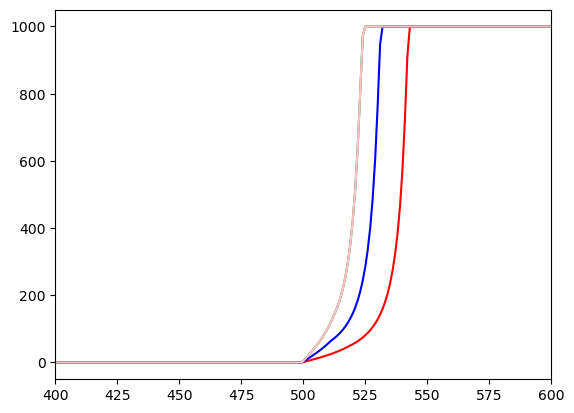

In [273]:
eve_st = events_array[events_array==32602853]
event_wf_st =  wfs[events_array==32602853]
energy_dep_st = energy_dep[events_array==32602853]
stack_wf = event_wf_st[0]*energy_dep_st[0]
plt.plot(event_wf_st[0],color='red')
plt.plot(event_wf_st[1],color='blue')
plt.plot(event_wf_st[2],color='green')
plt.plot(event_wf_st[2],color='pink')
plt.xlim(400,600)

(450.0, 600.0)

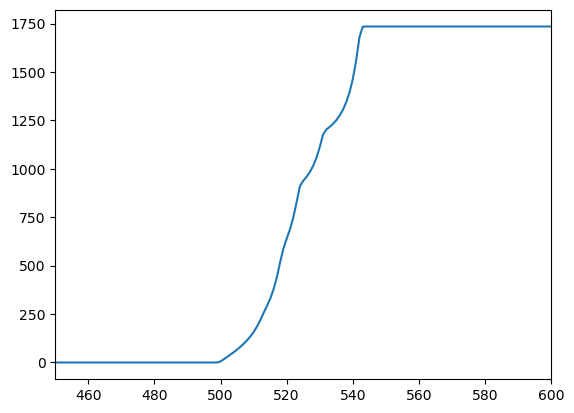

In [276]:

for i in range(1,len(eve_st)):
    stack_wf += event_wf_st[i]*energy_dep_st[i]
    # print(event_wf_st[i]*energy_dep_st[i])
    
plt.plot(stack_wf/np.sum(energy_dep_st))
plt.xlim(450,600)

In [17]:
if os.path.exists("g4simple_waveforms_bege"):
    shutil.rmtree("g4simple_waveforms_bege")
os.mkdir("g4simple_waveforms_bege")
# os.remove("my_stester_commands.txt")
f = open("my_stester_commands.txt", "w")
for i in range(0,len(x)):
    f.write("cart \n")
    f.write("tau 0\n")
    f.write("dif 1\n")
    f.write("ccs 1.0\n")
    f.write("sig %f %f %f g4simple_waveforms_bege/testx_%dy_%dz_%d.spe\n"%(x[i],y[i],z[i],x[i],y[i],z[i]))
f.write("quit\n")
f.close()

In [18]:
# hits = []
# z_cut = 152.9-30/2
# #15.2cm is height of the detector from bottom of cylinder and 30 is height of simulated detector

# with h5py.File(g4sfile_name, "r") as f:
#     # print(f['default_ntuples']['g4sntuple'].keys())
#     #cut out 0 energy deposition sites:
#     edep = np.array(f['default_ntuples']['g4sntuple']['Edep']['pages'])
#     x = np.array(f['default_ntuples']['g4sntuple']['x']['pages'])
#     y = np.array(f['default_ntuples']['g4sntuple']['y']['pages'])
#     z = np.array(f['default_ntuples']['g4sntuple']['z']['pages'])
#     evt = np.array(f['default_ntuples']['g4sntuple']['event']['pages'])
    
#     zerodep_flag = (edep!= 0)&(z>z_cut)
#     edep = edep[zerodep_flag]
#     x = x[zerodep_flag]
#     y = y[zerodep_flag]
#     z = z[zerodep_flag]
#     evt = evt[zerodep_flag]

    
#     for iev in range(evt.max()):
#         event_flag = evt == iev
#         numhit = np.sum(event_flag)
#         if numhit == 0:
#             continue
#         ev_edep = edep[event_flag]
#         ev_edep /= ev_edep.sum()
        
#         ev = []
#         for i in range(numhit):
#             ev.append([x[event_flag][i],y[event_flag][i],z[event_flag][i]-z_cut,ev_edep[i]])
#         hits.append(ev)
#     print(len(hits))
            

In [19]:
# import os
# import shutil
# if os.path.exists("g4simple_waveforms_bege"):
#     shutil.rmtree("g4simple_waveforms_bege")
# os.mkdir("g4simple_waveforms_bege")
# # os.remove("my_stester_commands.txt")
# f = open(siggen_dir+"my_stester_commands.txt", "w")
# for i,ev in enumerate(hits):
#     for j,hit in enumerate(ev):
#         f.write("cart \n")
#         f.write("tau 0\n")
#         f.write("dif 1\n")
#         f.write("ccs 1.0\n")
#         f.write("sig %f %f %f g4simple_waveforms_bege/test%d_%d.spe\n"%(hit[0],hit[1],hit[2],i,j))
# f.write("quit\n")
# f.close()

In [20]:
subprocess.run(siggen_dir + "stester config_files/bege_Sp.config < my_stester_commands.txt", stdout=subprocess.DEVNULL, check=False, shell=True)


CompletedProcess(args='/Users/kevinhbhimani/Desktop/cpu_net_sims/WFSimulation/icpc_siggen/stester config_files/bege_Sp.config < my_stester_commands.txt', returncode=0)

In [22]:
with open(save_file, 'wb') as handle:
    for i,fname in enumerate(os.listdir(waveform_dir),0):
        cwf = None
        if os.path.exists(os.path.join(waveform_dir,fname)):
            f = open(os.path.join(waveform_dir,fname), 'rb')
            head = f.read(36)
            yraw = f.read(500*4)
            y = np.array(struct.unpack('f'*500, yraw))
            wf = np.array([0]*500+list(y))
#             if cwf is None:
#                 cwf = wf*hits[i][j][-1]
#             else:
#                 cwf += wf*hits[i][j][-1]
#             print(cwf)
#             plt.plot(cwf)
#             plt.show()
#             assert 0
#             # if i>10:
#             #     assert 0
#             f.close()
            event_dict = {
                "tp0":500,\
                "wf":wf.astype(np.float32),\
            }
#             print(event_dict)
            pickle.dump(event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:

# with open("/Users/kevinhbhimani/Desktop/cpu_net_sims/BSimG4Simple.pickle", 'wb') as handle:
#     for i in range(len(hits)):
#         cwf = None
#         nhits = len(hits[i])
#         for j in range(nhits):
#             if not os.path.exists("g4simple_waveforms_bege/test%d_%d.spe"%(i,j)):
#                 continue
#             f = open("g4simple_waveforms_bege/test%d_%d.spe"%(i,j), 'rb')
#             head = f.read(36)
#             yraw = f.read(500*4)
#             y = np.array(struct.unpack('f'*500, yraw))
#             wf = np.array([0]*500+list(y))
#             if cwf is None:
#                 cwf = wf*hits[i][j][-1]
#             else:
#                 cwf += wf*hits[i][j][-1]
#         # print(cwf)
#         # plt.plot(cwf)
#         # assert 0
#         # # if i>10:
#         # #     assert 0
#         # f.close()
#         event_dict = {
#             "tp0":500,\
#             "wf":wf.astype(np.float32),\
#         }
#         pickle.dump(event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
from scipy.stats import qmc
sampler = qmc.Sobol(d=3, scramble=False)
wfbase = 15
sample = sampler.random_base2(m=wfbase)
numwf = 2**wfbase
print(sample.shape)
# x, y ,z, ccs, tau
l_bounds = [0,0,5]
u_bounds = [30,3.14,25]
sample = qmc.scale(sample, l_bounds, u_bounds)

(32768, 3)


In [ ]:
import os
import shutil
if os.path.exists("sobol_waveforms_bege"):
    shutil.rmtree("sobol_waveforms_bege")
os.mkdir("sobol_waveforms_bege")
os.remove("my_stester_commands.txt")
f = open("my_stester_commands.txt", "w")
for i,s in enumerate(sample):
    x, y, z = tuple(s)
    f.write("cyl\n")
    f.write("tau 0\n")
    f.write("sig %f %f %f sobol_waveforms_bege/test%d.spe\n"%(x,y,z,i))
f.write("quit\n")
f.close()

In [ ]:
subprocess.run("./stester config_files/bege_Sp.config < my_stester_commands.txt", stdout=subprocess.DEVNULL,check=False, shell=True)

CompletedProcess(args='./stester config_files/bege_Sp.config < my_stester_commands.txt', returncode=0)

In [ ]:
import os
import numpy as np
import struct
import matplotlib.pyplot as plt
import pickle
with open("/global/cfs/projectdirs/legend/users/liaobo77/Transformer/BSimSF.pickle", 'wb') as handle:
    for i in range(int(numwf)):
        if not os.path.exists("sobol_waveforms_bege/test%d.spe"%(i)):
            continue
        f = open("sobol_waveforms_bege/test%d.spe"%(i), 'rb')
        head = f.read(36)
        yraw = f.read(100*4)
        y = np.array(struct.unpack('f'*100, yraw))
        xx,yy,zz = tuple(sample[i])
        wf = [0]*500+list(y)
        plt.plot(wf)
        # if i>10:
        #     assert 0
        f.close()
        event_dict = {
            "runname": 0,\
            "wf":0,\
            "energy":0,\
            "tp0":500,\
            "wf":np.array(wf).astype(np.float32),\
        }
        pickle.dump(event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

FileNotFoundError: [Errno 2] No such file or directory: '/global/cfs/projectdirs/legend/users/liaobo77/Transformer/BSimSF.pickle'

In [ ]:
import sys
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
wfgrid = 5
cells = int((numwf/wfgrid)**0.5)+1
x = np.arange(0, 4000, 10)
# plt.subplot(cells, cells, 1)
iplot = 1
for i in range(256):
    if not os.path.exists("sobol_waveforms_bege/test%d.spe"%(i)):
        continue
    f = open("sobol_waveforms_bege/test%d.spe"%(i), 'rb')
    head = f.read(36)
    yraw = f.read(2000*4)
    y = np.array(struct.unpack('f'*2000, yraw))
    xx,yy,zz = tuple(sample[i])
    plt.plot(x,y,label="r: %.1f, rho: %.1f, z: %.1f"%(xx,yy,zz))
    # plt.plot(x,y)
    # plt.xlabel("Time [ns]", size=13)
    # plt.ylabel("Charge signal", labelpad=8,  size=13)
    # plt.title("siggen signal(s)\n", fontsize=16, linespacing=0.4)
    plt.grid(True)
    # plt.rcParams["figure.figsize"] = 12, 6
    f.close()
    if i != 0 and i%wfgrid == 0:
        plt.legend()
        plt.show()
        plt.close()

In [ ]:
import os
x = np.arange(0, 4000, 10)
dta = []
for z in np.arange(2,30,3.0):
    print("zpos:", z)
    try:
        # os.remove("my_stester_commands.txt")
        f = open("my_stester_commands.txt", "w")
        f.write("cyl\n")
        f.write("tau 6.8\n")
        f.write("ccs 0.5\n")
        # f.write("dp z%.2f.dat\n"%(z))
        f.write("sig 20.2 2.4 %f test.spe\n"%(z))
        f.write("quit\n")
        f.close()
        subprocess.run("./stester config_files/50372.config < my_stester_commands.txt", check=False, shell=True).stdout
        f = open("test.spe", 'rb')
        head = f.read(36)
        yraw = f.read(500*4)
        y = np.array(struct.unpack('f'*500, yraw))
        y_dt = y.max()*0.99
        dt = np.abs(y - y_dt).argmin()
        dta.append(dt)
        if z < 15:
            plt.plot(x,y,label="z = %f, dt = %f"%(z,dt),c="red")
        else:
            plt.plot(x,y,label="z = %f, dt = %f"%(z,dt),c="blue")
        f.close()
        os.remove("test.spe")
    except:
        '''
        '''
print("dtarray",dta)
plt.legend()
plt.xlabel("Time [ns]", size=13)
plt.ylabel("Charge signal", labelpad=8,  size=13)
plt.title("siggen signal(s)\n", fontsize=16, linespacing=0.4)
plt.xlim(0,2000)
plt.grid(True)
plt.rcParams["figure.figsize"] = 12, 6
plt.savefig("multiwf.png",dpi=200)
plt.show()
f.close()
f.close()
# subprocess.run("./stester config_files/50372.config < my_stester_commands.txt", check=False, shell=True).stdout
#subprocess.run("./stester config_files/coax_50372.config < my_stester_commands.txt", check=False, shell=True).stdout

## Plot AvsE

In [ ]:
import os
time_seg = 10
x = np.arange(0, 4000, time_seg)
twindow = 50
dta = []
for z in np.arange(2,30,3.0):
    print("zpos:", z)
    current_num_step = []
    current_amp_array = []
    os.remove("my_stester_commands.txt")
    f = open("my_stester_commands.txt", "w")
    f.write("cyl\n")
    f.write("tau 6.8\n")
    f.write("ccs 0.5\n")
    # f.write("dp z%.2f.dat\n"%(z))
    f.write("sig 20.2 2.4 %f test.spe\n"%(z))
    f.write("quit\n")
    f.close()
    subprocess.run("./stester config_files/50372.config < my_stester_commands.txt", check=False, shell=True, stdout=subprocess.DEVNULL)
    if not os.path.exists("test.spe"):
        continue
    f = open("test.spe", 'rb')
    head = f.read(36)
    yraw = f.read(400*4)
    y = np.array(struct.unpack('f'*400, yraw))
    y_dt = y.max()*0.99
    dt = np.abs(y - y_dt).argmin()
    dt_array.append(dt)
    cur_x = 0
    while cur_x + twindow <= 4000:
        cur_index = np.abs(cur_x-x).argmin()
        end_index = np.abs((cur_x+twindow)-x).argmin()
        x_array = x[cur_index:end_index+1]
        y_array = y[cur_index:end_index+1]
        p = np.polyfit(x_array,y_array,1)
        current_num_step.append(cur_x + twindow//2)
        current_amp_array.append(p[0])
        cur_x += twindow
    if z < 15:
        plt.plot(current_num_step,current_amp_array,label="z = %f, dt = %f"%(z,dt),c="red")
    else:
        plt.plot(current_num_step,current_amp_array,label="z = %f, dt = %f"%(z,dt),c="blue")
    f.close()
    os.remove("test.spe")
print("dtarray",dta)
plt.legend()
plt.xlabel("Time [ns]", size=13)
plt.ylabel("Charge signal", labelpad=8,  size=13)
plt.title("siggen signal(s)\n", fontsize=16, linespacing=0.4)
plt.xlim(0,2000)
plt.grid(True)
plt.rcParams["figure.figsize"] = 12, 6
plt.savefig("multiwf_current.png",dpi=200)
plt.show()
f.close()
f.close()
# subprocess.run("./stester config_files/50372.config < my_stester_commands.txt", check=False, shell=True).stdout
#subprocess.run("./stester config_files/coax_50372.config < my_stester_commands.txt", check=False, shell=True).stdout

In [ ]:
import matplotlib.colors as colors

data = np.loadtxt("fields/ev_50372.dat")
#data = np.loadtxt("fields/ev_c50372.dat")
# figure out the size of grid the X-Y points
x = set(data[:,0])  # sets only have one copy of anything, so if there are repeats, they are removed
y = set(data[:,1])
z = data[:,3]       # column 3 = field, 2 = potential
# reshape the zvals array into the appropriate shape, and find the boundaries
zvals = z.reshape(len(x), len(y))
zvals[zvals<0] = 0
# imshow plots columns and rows opposite to how you'd expect; so transpose them
zvals = zvals.T
# stack so we can plot the data from one half of the detector (positive r-values only)
zvals_neg = np.fliplr(zvals)
zvals_full = np.hstack((zvals_neg,zvals))
bounds = (-1*max(x), max(x), min(y), max(y))
print(bounds)

fig = plt.figure(figsize=(10,7))
ip = plt.imshow(zvals_full, norm=colors.LogNorm(),
                extent=bounds,   # set the boundaries of the edges of the 'image' data
                origin="lower",  # tell matplotlib where [0,0] is in the bottom
                cmap='jet')      # use the 'jet color map scheme
plt.xlabel("Radial position [mm]", size=13)
plt.ylabel("Axial position [mm]", labelpad=8,  size=13)
plt.colorbar()
for z in np.arange(12,45,6.0):
    plt.scatter([25.2],[z],color="blue")

# plt.scatter([24.8],[34.0],color="purple")
# plt.scatter([(3.2**2+2.9**2)**0.5],[33.0],color="purple")
plt.show()

## Generate drift time map

In [ ]:
import numpy as np
gsize = 100
rm = np.linspace(0,46,gsize)
zm = np.linspace(0,111,gsize)
R, Z = np.meshgrid(rm,zm)
DT = np.zeros((gsize, gsize))
print(R.shape,Z.shape)

In [ ]:
from tqdm import tqdm
if os.path.exists("dtmap_waveforms"):
    shutil.rmtree("dtmap_waveforms")
os.mkdir("dtmap_waveforms")
if os.path.exists("my_stester_commands_dt.txt"):
    os.remove("my_stester_commands_dt.txt")
f = open("my_stester_commands_dt.txt", "w")
import os
DT = np.zeros((gsize, gsize))
for i in tqdm( range(gsize)):
    for j in range(gsize):
        r = R[i,j]
        z = Z[i,j]
        for num_azimuthal in range(10):
            rho = np.pi * 2 / 10 * num_azimuthal
            f.write("cyl\n")
            f.write("tau 6.8\n")
            f.write("ccs 0.5\n")
            # f.write("dp z%.2f.dat\n"%(z))
            f.write("sig %f %f %f dtmap_waveforms/test_%d_%d_%d.spe\n"%(r,rho,z,i,j,num_azimuthal))
f.write("quit\n")
f.close()

In [ ]:
subprocess.run("./stester config_files/50372.config < my_stester_commands_dt.txt", check=False, shell=True, stdout=subprocess.DEVNULL)

In [ ]:
import sys
import numpy as np
import struct
import matplotlib.pyplot as plt
import os
DT = np.zeros((gsize, gsize))
for i in range(gsize):
    for j in range(gsize):
        dt_array = []
        for n in range(10):
            fname = "dtmap_waveforms/test_%d_%d_%d.spe"%(i,j,0)
            if not os.path.exists(fname):
                continue
            f = open(fname, 'rb')
            head = f.read(36)
            yraw = f.read(400*4)
            y = np.array(struct.unpack('f'*400, yraw))
            y_dt = y.max()*0.99
            dt = np.abs(y - y_dt).argmin()
            dt_array.append(dt)
        if len(dt_array) != 0:
            DT[i,j] = np.mean(dt_array)


In [ ]:
print(DT)

In [ ]:
import matplotlib.colors as colors
def dup(inp, flipsign = False):
    rinp = np.fliplr(inp)
    if flipsign:
        rinp = -rinp
    return np.hstack((rinp,inp))
plt.figure(figsize=(10,7))
PR = dup(R,flipsign=True)
PZ = dup(Z)
PDT = dup(DT)
plt.pcolormesh(PR, PZ, PDT,edgecolors="face",norm=colors.LogNorm())
for z in np.arange(12,45,6.0):
    plt.scatter([25.2],[z],color="blue")
plt.xlim(-46,46)
plt.ylim(0,111)
plt.savefig("dtmap.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()
plt.figure(figsize=(7,10))
plt.contour(PR, PZ, PDT,edgecolors="face",levels=50)
rindex = np.abs(25.2-rm).argmin()
for z in np.arange(12,45,6.0):
    zindex = np.abs(z-zm).argmin()
    print(R[zindex,rindex],Z[zindex,rindex],DT[zindex,rindex])
    plt.scatter([25.2],[z],color="blue")
plt.xlim(-46,46)
plt.ylim(0,111)
plt.savefig("dtcontour.png",dpi=200)
plt.show()
plt.cla()
plt.clf()
plt.close()

In [ ]:
print(dup(R,flipsign=True))

In [37]:
g4sfile_name = "/work/users/k/b/kbhimani/cpu_net_g4sims/data/data_run_" + str(0) + ".hdf5"
# print("procession file:", g4sfile_name)
g4sfile = h5py.File(g4sfile_name, 'r')
g4sntuple = g4sfile['default_ntuples']['g4sntuple']
# print("Importing data")
#SEP CUTs
energy_cut_l= 2.100
energy_cut_h= 2.105

#FEP CUTs
# energy_cut_l= 2.611
# energy_cut_h= 2.616
# Creating a DataFrame
g4sdf = pd.DataFrame({
    'x_hit': np.array(g4sntuple['x']['pages']),
    'y_hit': np.array(g4sntuple['y']['pages']),
    'z_hit': np.array(g4sntuple['z']['pages']),
    'event': np.array(g4sntuple['event']['pages']),
    'Edep': np.array(g4sntuple['Edep']['pages']),
    'volID': np.array(g4sntuple['volID']['pages']),
    'iRep': np.array(g4sntuple['iRep']['pages'])
})

# print("Processing data")
# Filtering and grouping operations
detector_hits = g4sdf[(g4sdf.Edep > 0) & (g4sdf.volID == 1)]

# Group by 'event' and sum the 'Edep' values, and rename the column to 'total_energy'
grouped_hits = detector_hits.groupby('event', as_index=False).agg({'Edep': 'sum'}).rename(columns={'Edep': 'total_energy'})

# Filter to include only rows where the total 'total_energy' is between 2.1 and 2.105
selected_events = grouped_hits[(grouped_hits['total_energy'] > energy_cut_l) & (grouped_hits['total_energy'] < energy_cut_h)]

# Merge the total energy information back to the original DataFrame based on the 'event'
selected_events_detailed = detector_hits.merge(selected_events, on='event', how='right')

# Now, the 'selected_events_detailed' DataFrame should have all the original columns plus the 'total_energy' column.
# print("Unique events in the run", len(np.unique(selected_events_detailed["event"])))

clust_eps = 0.1 # distance for which two points are considered neighbors in DBSCAN
event_list = np.unique(selected_events_detailed["event"])
g4sfile.close()



In [38]:
print(selected_events_detailed)

           x_hit     y_hit       z_hit    event      Edep  volID  iRep  \
0      21.570876  0.665034  162.571314    47792  0.017649      1     0   
1      21.558542  0.664910  162.585602    47792  0.009952      1     0   
2      21.505519  0.668115  162.635615    47792  0.034574      1     0   
3      21.461424  0.670364  162.662261    47792  0.018885      1     0   
4      21.426700  0.666272  162.665954    47792  0.012344      1     0   
...          ...       ...         ...      ...       ...    ...   ...   
23720 -16.824174 -1.391229  143.681229  9938869  0.011250      1     0   
23721 -16.825679 -1.395487  143.678538  9938869  0.005902      1     0   
23722 -16.753530 -1.393489  143.603039  9938869  0.010556      1     0   
23723 -16.729512 -1.395052  143.579258  9938869  0.011029      1     0   
23724 -16.724333 -1.395231  143.573888  9938869  0.004636      1     0   

       total_energy  
0          2.103505  
1          2.103505  
2          2.103505  
3          2.103505  
4

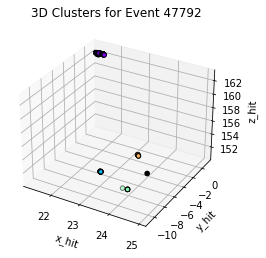

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from sklearn.cluster import DBSCAN

# Assuming clust_eps, selected_events_detailed, and event_list are defined
model = DBSCAN(eps=0.5)

for i in event_list:
    data_load = selected_events_detailed[selected_events_detailed["event"] == i]
    e_event = data_load["Edep"].sum()  # Total energy for the event
    data = data_load[['x_hit', 'y_hit', 'z_hit']]
    pred = model.fit_predict(data)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot clusters
    unique_labels = set(pred)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise
            col = 'k'

        class_member_mask = (pred == k)
        xy = data[class_member_mask]
        ax.scatter(xy["x_hit"], xy["y_hit"], xy["z_hit"], c=[col], marker='o', edgecolor='k')

    ax.set_title(f'3D Clusters for Event {i}')
    ax.set_xlabel('x_hit')
    ax.set_ylabel('y_hit')
    ax.set_zlabel('z_hit')
    plt.show()  # Show the plot
    break
    # ... rest of your code ...


In [20]:
%%time
#change save_dir, clust_dir and file save name and this line: save_file=save_dir+ "fep_sim"+str(run_num)+".pickle"
delete_files_in_directory(waveform_dir + "unstacked_wf/")
delete_files_in_directory(waveform_dir + "stacked_wf/")
import pandas as pd
import numpy as np
import glob  # import the glob module to find all the files matching a pattern
import subprocess
import os
import struct
import pickle
from tqdm import tqdm
siggen_dir='/nas/longleaf/home/kbhimani/cpu_net_sims/WFSimulation/icpc_siggen/'
clust_dir= "/nas/longleaf/home/kbhimani/cpu_net_sims/clust_data/fep/"
waveform_dir="/work/users/k/b/kbhimani/cpu_net_siggen_sims/waveforms/"
save_dir="/nas/longleaf/home/kbhimani/cpu_net_sims/waveforms/run_wfs/fep/"
z_cut = 152.9-30/2
def delete_files_in_directory(directory_path):
    # Get a list of all files in the directory
    files = glob.glob(directory_path + '*')
    for file in files:
        try:
            os.remove(file)  # Try to delete each file
            # print(f"File {file} deleted successfully")
        except Exception as e:
            print(f"An error occurred while deleting the file {file}: {e}")
run_dir= clust_dir+"cpu_net_data_clust_"+str(0)+'.h5'
# print("procession file:", run_dir)
df = pd.read_hdf(run_dir)
edep = df["e_hit"].to_numpy()
e_total = df["e_event"].to_numpy()
x = df["x_hit"].to_numpy()
y = df["y_hit"].to_numpy()
z = df["z_hit"].to_numpy()
event = df["event"].to_numpy()
df.loc[df['z_hit'] > (z_cut), 'z_hit'] -= z_cut
# print(f"Attempting to write to: {waveform_dir}my_stester_commands.txt")
initial_energy_per_event = df.groupby('event')['e_hit'].sum()


CPU times: user 7.44 ms, sys: 2.69 ms, total: 10.1 ms
Wall time: 19.8 ms


In [21]:
f = open(waveform_dir+"my_stester_commands.txt", "w")
for i in range(0,len(x)):
    f.write("cart \n")
    f.write("tau 0\n")
    f.write("dif 1\n")
    f.write("ccs 0.1\n")
    str1 = "sig %f %f %f "%(x[i],y[i],z[i])
    str2 = waveform_dir+"unstacked_wf/sig_event%d_x_%.4fy_%.4fz_%.4f.spe\n"%(event[i],np.round(x[i],4),np.round(y[i],4),np.round(z[i],4))
    f.write(str1+str2)
f.write("quit\n")
f.close()
# print("Running Siggen to generate waveforms")
os.chdir(siggen_dir)
sterster_comand = siggen_dir + "stester " + siggen_dir+ "config_files/bege_Sp.config < " + waveform_dir + "my_stester_commands.txt"
# print(sterster_comand)
subprocess.run(sterster_comand, stdout=subprocess.DEVNULL, check=False, shell=True) #, stdout=subprocess.DEVNULL
wfs=[]
events_array=[]
energy_dep=[]
for j in range(0,len(x)):
    unstack_wf_dir = waveform_dir+"/unstacked_wf/sig_event%d_x_%.4fy_%.4fz_%.4f.spe"%(event[j],np.round(x[j],4),np.round(y[j],4),np.round(z[j],4))
    wf=0
    try:
        f = open(unstack_wf_dir, 'rb')
        head = f.read(36)
        yraw = f.read(500*4)
        y_wf = np.array(struct.unpack('f'*500, yraw))
        wf = np.array([0]*500+list(y_wf))
    except (FileNotFoundError):
        continue
    wfs.append(wf)
    events_array.append(event[j])
    energy_dep.append(edep[j])
wfs = np.asarray(wfs)
events_array=np.asarray(events_array)
energy_dep = np.asarray(energy_dep)
# print("Number of unique events:", len(np.unique(events_array)))

In [22]:
post_processed_energy = pd.DataFrame({
    'event': events_array,
    'energy_dep': energy_dep
}).groupby('event')['energy_dep'].sum()

energy_comparison = pd.DataFrame({
    'initial_energy': initial_energy_per_event,
    'post_processed_energy': post_processed_energy
})
energy_comparison['difference'] = energy_comparison['post_processed_energy'] - energy_comparison['initial_energy']


In [ ]:
for e in np.unique(events_array):
    eve_st = events_array[events_array==e]
    event_wf_st =  wfs[events_array==e]
    energy_dep_st = energy_dep[events_array==e]
    stack_wf = event_wf_st[0]*energy_dep_st[0]
    for i in range(0,len(eve_st)):
        stack_wf += event_wf_st[i]*energy_dep_st[i]
    final_stacked = stack_wf/np.sum(energy_dep_st)
    np.savetxt(waveform_dir+"/stacked_wf/" + 'wf_event_%d_energy_%d.txt'%(e,np.sum(energy_dep_st)*1000),final_stacked)
save_file=save_dir+ "fep_sim"+str(run_num)+".pickle"

# print("Saving the waveforms in:", save_file)
with open(save_file, 'wb') as handle:
    for i,fname in enumerate(os.listdir(waveform_dir+"stacked_wf/"),0):
        path = os.path.join(waveform_dir+"stacked_wf/",fname)
        if os.path.exists(path):
            wf = np.loadtxt(path)
            event_dict = {
                "tp0":500,\
                "wf":wf.astype(np.float32),\
            }
            pickle.dump(event_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
os.remove(waveform_dir+"my_stester_commands.txt")
delete_files_in_directory(waveform_dir + "unstacked_wf/")
delete_files_in_directory(waveform_dir + "stacked_wf/")